<a href="https://colab.research.google.com/github/TA-PP/SKT-FLY-AI/blob/main/FLY_Day13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 데이터 증강
기존의 데이터를 변형해서 데이터의 양을 늘리는 것을 데이터 증강이라고 한다.

In [1]:
# 훈련용 이미지
!wget --no-check-certificate \
  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps.zip \
  -O /tmp/rps.zip

--2023-01-04 02:22:00--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.217.128, 173.194.218.128, 108.177.11.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.217.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 200682221 (191M) [application/zip]
Saving to: ‘/tmp/rps.zip’

/tmp/rps.zip        100%[===================>] 191.38M   205MB/s    in 0.9s    

2023-01-04 02:22:01 (205 MB/s) - ‘/tmp/rps.zip’ saved [200682221/200682221]



In [2]:
# 테스트용 이미지
!wget --no-check-certificate \
  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps-test-set.zip \
  -O /tmp/rps-test-set.zip

--2023-01-04 02:22:01--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps-test-set.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.217.128, 173.194.218.128, 108.177.11.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.217.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29516758 (28M) [application/zip]
Saving to: ‘/tmp/rps-test-set.zip’

/tmp/rps-test-set.z 100%[===================>]  28.15M  46.9MB/s    in 0.6s    

2023-01-04 02:22:02 (46.9 MB/s) - ‘/tmp/rps-test-set.zip’ saved [29516758/29516758]



In [3]:
# 압축 풀기
import os # 라이브러리를 통해 파일 시스템에 접근 가능
import zipfile # 라이브러리의 zipfile 클래스로 zip 파일을 연 후

local_zip = '/tmp/rps.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/') # 메서드를 이용해서 tmp 폴더에 압축을 푼다.
zip_ref.close()

local_zip = '/tmp/rps-test-set.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/')
zip_ref.close()

In [4]:
# 경로 지정하기
rock_dir = os.path.join('/tmp/rps/rock')
paper_dir = os.path.join('/tmp/rps/paper')
scissors_dir = os.path.join('/tmp/rps/scissors')

rock_files = os.listdir(rock_dir)
paper_files = os.listdir(paper_dir)
scissors_files = os.listdir(scissors_dir)

print('Total number of training rock images:', len(rock_files))
print('Total number of training paper images:', len(paper_files))
print('Total number of training scissors images:', len(scissors_files))

print(rock_files[:10])
print(paper_files[:10])
print(scissors_files[:10])

Total number of training rock images: 840
Total number of training paper images: 840
Total number of training scissors images: 840
['rock04-098.png', 'rock02-119.png', 'rock04-024.png', 'rock04-071.png', 'rock01-102.png', 'rock07-k03-108.png', 'rock05ck01-036.png', 'rock01-046.png', 'rock03-078.png', 'rock03-057.png']
['paper01-118.png', 'paper06-010.png', 'paper01-042.png', 'paper05-105.png', 'paper07-053.png', 'paper02-064.png', 'paper05-110.png', 'paper06-042.png', 'paper01-102.png', 'paper05-048.png']
['testscissors01-041.png', 'testscissors02-102.png', 'scissors04-089.png', 'scissors02-048.png', 'scissors04-073.png', 'testscissors02-047.png', 'scissors01-116.png', 'scissors01-029.png', 'testscissors01-016.png', 'testscissors03-074.png']


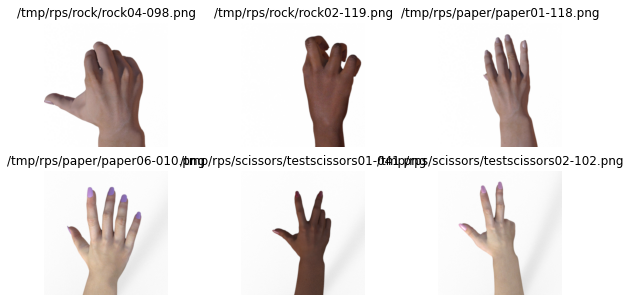

In [17]:
# 이미지 확인하기
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

pic_index = 2

next_rock = [os.path.join(rock_dir, fname) for fname in rock_files[pic_index-2:pic_index]]
next_paper = [os.path.join(paper_dir, fname) for fname in paper_files[pic_index-2:pic_index]]
next_scissors = [os.path.join(scissors_dir, fname) for fname in scissors_files[pic_index-2:pic_index]]

plt.figure(figsize=(10, 5))

for i, img_path in enumerate(next_rock + next_paper + next_scissors):
    plt.subplot(2, 3, i+1)
    plt.title(img_path)
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.axis('Off')

plt.show()

In [6]:
# 모델 구성 / 훈련하기
import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

TRAINING_DIR = "/tmp/rps/"
training_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

VALIDATION_DIR = "/tmp/rps-test-set/"
validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
TRAINING_DIR,
target_size=(150,150),
class_mode='categorical',
batch_size=126
)

validation_generator = validation_datagen.flow_from_directory(
VALIDATION_DIR,
target_size=(150,150),
class_mode='categorical',
batch_size=126
)

model = tf.keras.models.Sequential([
  # Note the input shape is the desired size of the image 150x150 with 3 bytes color
  # This is the first convolution
  tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
  tf.keras.layers.MaxPooling2D(2, 2),
  # The second convolution
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  # The third convolution
  tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  # The fourth convolution
  tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  # Flatten the results to feed into a DNN
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dropout(0.5),
  # 512 neuron hidden layer
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(3, activation='softmax')
])
model.summary()

model.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
history = model.fit(train_generator, epochs=25, steps_per_epoch=20, validation_data = validation_generator, verbose = 1, validation_steps=3)
model.save("rps.h5")

Found 2520 images belonging to 3 classes.
Found 372 images belonging to 3 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                       

In [10]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_history(history):
  hist=pd.DataFrame(history.history)
  hist['epoch']=history.epoch
  plt.figure(figsize=(16,8))
  
  plt.subplot(1,2,1)
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.plot(hist['epoch'],hist['loss'],label='Train Loss')
  plt.plot(hist['epoch'],hist['val_loss'],label='val_loss')
  plt.legend()

  plt.subplot(1,2,2)
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.plot(hist['epoch'],hist['accuracy'], label="Train Accuracy")
  plt.plot(hist['epoch'],hist['val_accuracy'],label='Val Accuracy')
  plt.legend()

  plt.show()

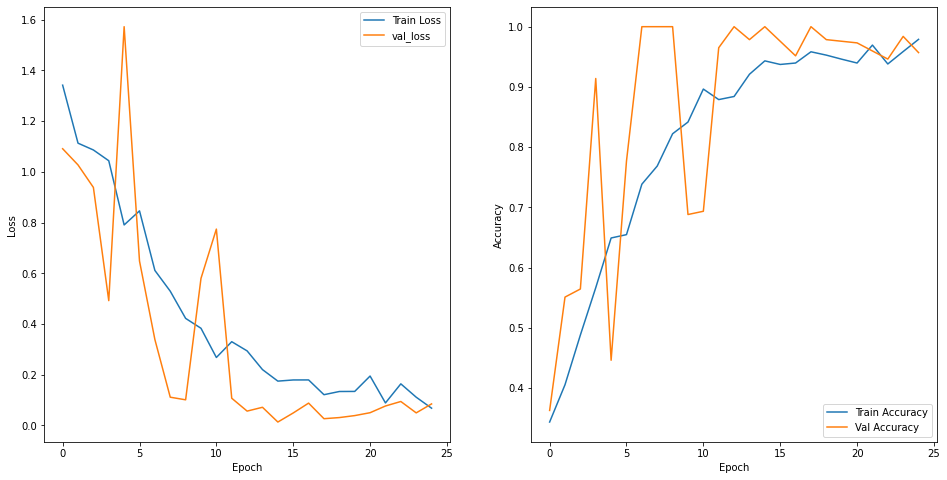

In [11]:
plot_history(history)

In [12]:
loss, acc = model.evaluate(validation_generator)
print('loss : ', loss)
print('acc : ', acc)

3/3 [==============================] - 1s 390ms/step - loss: 0.0848 - accuracy: 0.9570
loss :  0.08483380824327469
acc :  0.9569892287254333


In [19]:
# 모델 저장하기
from keras.models import load_model

model_name = 'rock_paper_scissors_cnn.h5'
model.save(model_name)